Environment Summary: Continuous Random Walk (1D)

This environment represents a continuous one-dimensional space with boundaries at 0.0 and 1.0.
The agent starts at the center (0.5) and can move left or right in small steps with added Gaussian noise.
The movement is defined by a fixed step size (e.g., 0.03) plus noise sampled from a normal distribution.

- State Space: Continuous in [0.0, 1.0]
- Action Space: {0: Left, 1: Right}
- Rewards:
    * +10 if the agent reaches the right terminal state (state ≥ 1.0)
    * -10 if the agent reaches the left terminal state (state ≤ 0.0)
    * -1 for all intermediate steps
- Episode ends when the agent reaches either terminal state.



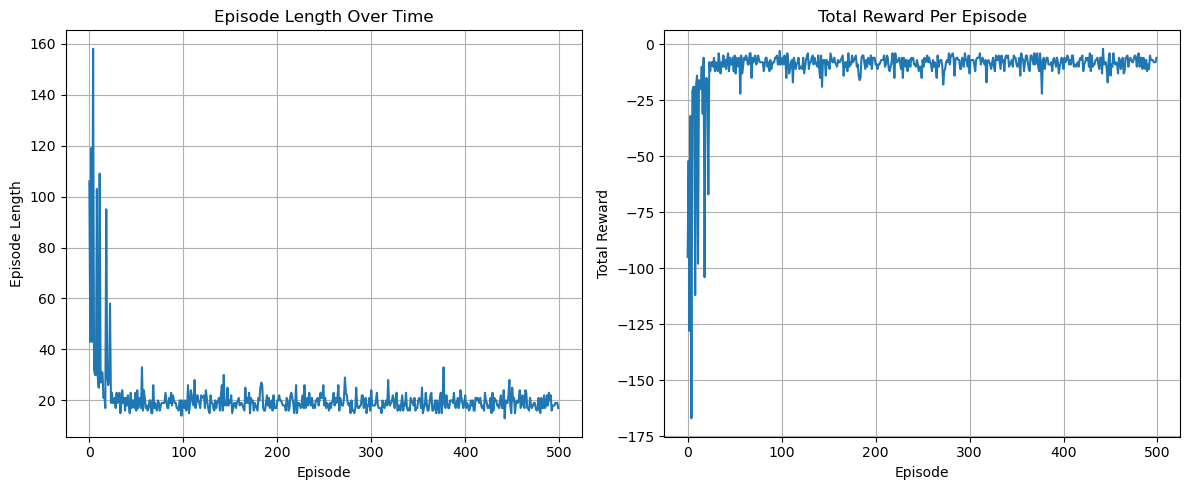

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Tile coding helper
class TileCoder:
    def __init__(self, num_tilings, tiles_per_tiling, low, high):
        self.num_tilings = num_tilings
        self.tiles_per_tiling = tiles_per_tiling
        self.low = low
        self.high = high
        self.tile_width = (high - low) / tiles_per_tiling
        self.offsets = np.linspace(0, self.tile_width, num_tilings, endpoint=False)

    def get_features(self, s, a):
        features = np.zeros(self.num_tilings * self.tiles_per_tiling * 2)
        for i in range(self.num_tilings):
            shifted_s = s + self.offsets[i]
            pos = math.floor((shifted_s - self.low) / self.tile_width)
            pos = min(max(pos, 0), self.tiles_per_tiling - 1)
            index = i * self.tiles_per_tiling * 2 + pos * 2 + a
            features[index] = 1
        return features

# Continuous environment
class ContinuousRandomWalkEnv:
    def __init__(self, step_size=0.2, noise_std=0.01, terminal=True):
        self.step_size = step_size
        self.noise_std = noise_std
        self.terminal = terminal
        self.reset()

    def reset(self):
        self.state = 0.5
        return self.state

    def step(self, action):
        move = self.step_size if action == 1 else -self.step_size
        self.state += move + np.random.normal(0, self.noise_std)
        self.state = np.clip(self.state, 0.0, 1.0)
        done = self.terminal and (self.state <= 0.0 or self.state >= 1.0)
        reward = 10.0 if self.state >= 1.0 else -10.0 if self.state <= 0.0 else -1.0
        return self.state, reward, done

# Sarsa agent
class SemiGradientSarsaAgent:
    def __init__(self, tile_coder, alpha, gamma, epsilon):
        self.tc = tile_coder
        self.alpha = alpha / tile_coder.num_tilings
        self.gamma = gamma
        self.epsilon = epsilon
        self.w = np.zeros(tile_coder.num_tilings * tile_coder.tiles_per_tiling * 2)

    def select_action(self, s):
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1])
        return np.argmax([self.get_q(s, 0), self.get_q(s, 1)])

    def get_q(self, s, a):
        return np.dot(self.w, self.tc.get_features(s, a))

    def update(self, s, a, r, s_next, a_next):
        features = self.tc.get_features(s, a)
        target = r + self.gamma * self.get_q(s_next, a_next)
        prediction = np.dot(self.w, features)
        self.w += self.alpha * (target - prediction) * features

# Training
def train(env, agent, num_episodes=500):
    episode_lengths = []
    episode_returns = []
    state_visits = np.zeros(100)
    for ep in range(num_episodes):
        s = env.reset()
        a = agent.select_action(s)
        steps = 0
        total_reward = 0.0
        while True:
            bin_index = int(s * len(state_visits))
            state_visits[bin_index] += 1
            s_next, r, done = env.step(a)
            a_next = agent.select_action(s_next)
            agent.update(s, a, r, s_next, a_next)
            s, a = s_next, a_next
            steps += 1
            total_reward += r
            if done:
                break
        episode_lengths.append(steps)
        episode_returns.append(total_reward)
    return episode_lengths, episode_returns, state_visits, agent


# Plotting
def plot_training_metrics(lengths, returns):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length Over Time")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(returns)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward Per Episode")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run 
np.random.seed(42)
env = ContinuousRandomWalkEnv(step_size=0.03, terminal=True)
tile_coder = TileCoder(num_tilings=10, tiles_per_tiling=8, low=0.0, high=1.0)
agent = SemiGradientSarsaAgent(tile_coder, alpha=0.1, gamma=0.99, epsilon=0.1)

lengths, returns, visits, trained_agent = train(env, agent, num_episodes=500)

plot_training_metrics(lengths, returns)

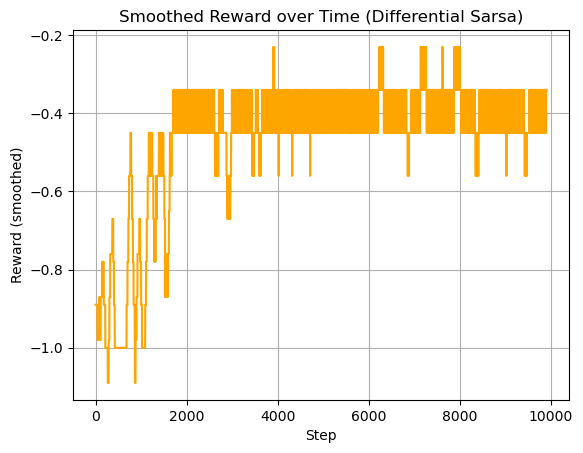

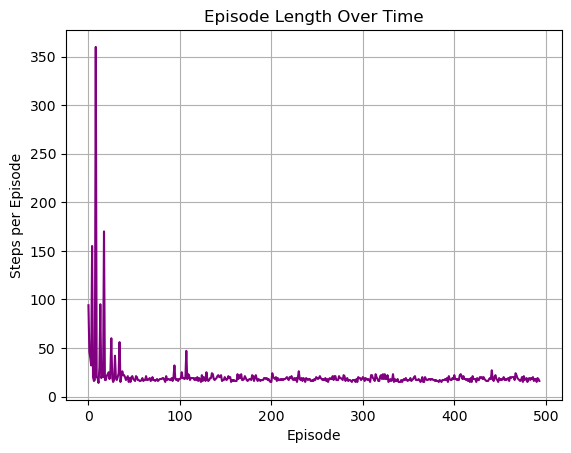

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Tile coding
class TileCoder:
    def __init__(self, num_tilings, tiles_per_tiling, low, high):
        self.num_tilings = num_tilings
        self.tiles_per_tiling = tiles_per_tiling
        self.low = low
        self.high = high
        self.tile_width = (high - low) / tiles_per_tiling
        self.offsets = np.linspace(0, self.tile_width, num_tilings, endpoint=False)

    def get_features(self, s, a):
        features = np.zeros(self.num_tilings * self.tiles_per_tiling * 2)
        for i in range(self.num_tilings):
            shifted_s = s + self.offsets[i]
            pos = math.floor((shifted_s - self.low) / self.tile_width)
            pos = min(max(pos, 0), self.tiles_per_tiling - 1)
            index = i * self.tiles_per_tiling * 2 + pos * 2 + a
            features[index] = 1
        return features

# Environment
class ContinuousRandomWalkEnv:
    def __init__(self, step_size=0.03, noise_std=0.01, terminal=True):
        self.step_size = step_size
        self.noise_std = noise_std
        self.terminal = terminal
        self.reset()

    def reset(self):
        self.state = 0.5
        return self.state

    def step(self, action):
        move = self.step_size if action == 1 else -self.step_size
        self.state += move + np.random.normal(0, self.noise_std)
        self.state = np.clip(self.state, 0.0, 1.0)
        done = self.terminal and (self.state <= 0.0 or self.state >= 1.0)
        reward = 10.0 if self.state >= 1.0 else -10.0 if self.state <= 0.0 else -1.0
        return self.state, reward, done

# Differential Sarsa Agent
class DifferentialSarsaAgent:
    def __init__(self, tile_coder, alpha, beta, epsilon):
        self.tc = tile_coder
        self.alpha = alpha / tile_coder.num_tilings
        self.beta = beta
        self.epsilon = epsilon
        self.avg_reward = 0.0
        self.w = np.zeros(tile_coder.num_tilings * tile_coder.tiles_per_tiling * 2)

    def select_action(self, s):
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1])
        return np.argmax([self.get_q(s, 0), self.get_q(s, 1)])

    def get_q(self, s, a):
        return np.dot(self.w, self.tc.get_features(s, a))

    def update(self, s, a, r, s_next, a_next):
        x = self.tc.get_features(s, a)
        x_next = self.tc.get_features(s_next, a_next)
        delta = r - self.avg_reward + np.dot(self.w, x_next) - np.dot(self.w, x)
        self.avg_reward += self.beta * delta
        self.w += self.alpha * delta * x

# Training loop with episode length tracking
def train(env, agent, steps=10000):
    rewards = []
    visits = np.zeros(100)
    episode_lengths = []
    s = env.reset()
    a = agent.select_action(s)
    steps_in_episode = 0

    for _ in range(steps):
        bin_index = int(s * len(visits))
        visits[bin_index] += 1
        s_next, r, done = env.step(a)
        a_next = agent.select_action(s_next)
        agent.update(s, a, r, s_next, a_next)
        rewards.append(r)
        steps_in_episode += 1
        if done:
            episode_lengths.append(steps_in_episode)
            s = env.reset()
            a = agent.select_action(s)
            steps_in_episode = 0
        else:
            s, a = s_next, a_next

    return rewards, visits, episode_lengths, agent


# Plotting
def plot_rewards(rewards):
    avg = np.convolve(rewards, np.ones(100)/100, mode='valid')
    plt.figure()
    plt.plot(avg, color='orange')
    plt.title("Smoothed Reward over Time (Differential Sarsa)")
    plt.xlabel("Step")
    plt.ylabel("Reward (smoothed)")
    plt.grid(True)
    plt.show()


def plot_episode_lengths(episode_lengths):
    plt.figure()
    plt.plot(episode_lengths, color='purple')
    plt.title("Episode Length Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Steps per Episode")
    plt.grid(True)
    plt.show()

#  run
np.random.seed(42)
env = ContinuousRandomWalkEnv(step_size=0.03, terminal=True)
tile_coder = TileCoder(num_tilings=10, tiles_per_tiling=8, low=0.0, high=1.0)
agent = DifferentialSarsaAgent(tile_coder, alpha=0.1, beta=0.01, epsilon=0.05)

rewards, visits, episode_lengths, trained_agent = train(env, agent, steps=10000)

# Visualize
plot_rewards(rewards)
plot_episode_lengths(episode_lengths)
